In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import cartopy.crs as ccrs
import cartopy as cart
import cmocean
import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch.nn import Sequential as Seq, Linear, ReLU
from Networks import *
from Data_Functions import *
from matplotlib.animation import FuncAnimation
from Utils import *
from Subgrid_Funcs import *
from Eval_Funcs import *
from Parallel import *
import numpy.fft as fft
import sys
import copy_things as copy
import scipy as sp

import matplotlib.ticker as ticker


In [39]:
exp_num_in = "3"
exp_num_extra = "5"
exp_num_out = "2"


mse = torch.nn.MSELoss()

region = "Gulf_Stream_Ext"   
network = "U_net"

interval = 2

N_samples = 2000
N_val = 100
N_test = 1500

Nb = 4

factor = 10

hist = 0

lag = 1

steps = 1

if len(sys.argv) > 4:
    n_cond = int((len(sys.argv)-4)/2)

str_video = ""

try:
    for i in range(n_cond):
        if type(globals()[sys.argv[int(4 + i*2)]]) == str:
            temp = str(sys.argv[int(5 + i*2)])
            exec(sys.argv[int(4 + i*2)] +"= temp" )
            if sys.argv[int(4 + i*2)] == "network":
                continue
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
        elif type(globals()[sys.argv[int(4 + i*2)]]) == int:
            exec(sys.argv[int(4 + i*2)] +"=" + "int(" + sys.argv[int(5 + i*2)] +")" )
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
    print(str_video)
except:
    print("no cond")

    
if region == "Kuroshio":
    lat = [15,41]
    lon = [-215, -185]
elif region == "Kuroshio_Ext":
    lat = [5,50]
    lon = [-250, -175]      
elif region == "Gulf_Stream":
    lat = [25, 50]
    lon = [-70,-35]
elif region == "Gulf_Stream_Ext":
    lat = [27, 50]
    lon = [-82,-35]       
elif region == "Tropics":
    lat = [-5,25]
    lon = [-95,-65]  
elif region == "Tropics_Ext":
    lat = [-5,25]
    lon = [-115,-45]     
elif region == "South_America":
    lat = [-60, -30]
    lon = [-70,-35] 
elif region == "Africa":
    lat = [-50, -20]
    lon = [5,45] 
elif region == "Quiescent":
    lat = [-42.5, -17.5]
    lon = [-155,-120] 
elif region == "Quiescent_Ext":
    lat = [-55, -10]
    lon = [-170,-110]            
elif region == "Pacific":
    lat = [-35, 35]
    lon = [-230,-80]     
elif region == "Indian":
    lat = [-30, 28]
    lon = [30,79]   
elif region == "Africa_Ext":
    lat = [-55, -15]
    lon = [-5,55]        
        
s_train = lag*hist
e_train = s_train + N_samples*interval
e_test = e_train + interval*N_val



device = "cpu"


inpt_dict = {"1":["um","vm"],"2":["um","vm","ur","vr"],"3":["um","vm","Tm"],
            "4":["um","vm","ur","vr","Tm","Tr"],"5":["ur","vr"],"6":["ur","vr","Tr"],
            "7":["Tm"],"8":["Tm","Tr"],"9":["u","v"],"10":["u","v","T"],
            "11":["tau_u","tau_v"]} 
extra_dict = {"1":["ur","vr"],"2":["ur","vr","Tm"],
            "3":["Tm"],"4":["ur","vr","Tm","Tr"],"5":[],"6":["um","vm"],
             "7":["um","vm","Tm"], "8": ["um","vm","Tm","Tr"],
              "9":["ur","vr","tau_u","tau_v"],"10":["tau_u","tau_v"],
              "11":["ur","vr","Tr"],"12":["tau_u","tau_v","t_ref"]} 
out_dict = {"1":["um","vm"],"2":["um","vm","Tm"],"3":["ur","vr"],
           "4":["ur","vr","Tr"],"5":["u","v"],"6":["u","v","T"]}


grids = xr.open_dataset('/scratch/zanna/data/CM2_grids/Grid_cm25_Vertices.nc')
if "global" in region:
    grids = coarse_grid(grids,factor)

else:
    grids = grids.sel({"yu_ocean":slice(lat[0],lat[1]),"xu_ocean":slice(lon[0],lon[1])})


area = torch.from_numpy(grids["area_C"].to_numpy()).to(device=device)
dx = grids["dxu"].to_numpy()
dy = grids["dyu"].to_numpy()



inputs = inpt_dict[exp_num_in]
extra_in = extra_dict[exp_num_extra]
outputs = out_dict[exp_num_out]

str_in = "".join([i + "_" for i in inputs])
str_ext = "".join([i + "_" for i in extra_in])
str_out = "".join([i + "_" for i in outputs])

print("inputs: " + str_in)
print("extra inputs: " + str_ext)
print("outputs: " + str_out)

N_atm = len(extra_in)
N_in = len(inputs)
N_extra = N_atm + N_in
N_out = len(outputs)

num_in = int((hist+1)*N_in + N_extra)

if "global" in region:
    inputs, extra_in, outputs = gen_data_global(inputs,extra_in,outputs,lag)
else:
    inputs, extra_in, outputs = inputs, extra_in, outputs = gen_data_025_lateral(inputs,extra_in,outputs,lag,lat,lon,Nb)


wet = xr.zeros_like(inputs[0][0])
# inputs[0][0,12,12] = np.nan
for data in inputs:
    wet +=np.isnan(data[0])
wet_nan = xr.where(wet!=0,np.nan,1).to_numpy()
wet = xr.where(wet==0,np.nan,0)    
wet_xr = wet.copy()
wet = np.isnan(wet)
wet = np.nan_to_num(wet.to_numpy())
wet = torch.from_numpy(wet).type(torch.float32).to(device=device)
wet_bool = np.array(wet.cpu()).astype(bool)

wet_lap = compute_laplacian_wet(wet_nan,Nb)
wet_lap = xr.where(wet_lap==0,1,np.nan)
wet_lap = np.nan_to_num(wet_lap)
wet_lap_bool = np.array(wet_lap).astype(bool)
# wet_lap = torch.from_numpy(wet_lap).type(torch.float32).to(device=device)


time_vec = inputs[0].time.data

no cond
inputs: um_vm_Tm_
extra inputs: 
outputs: um_vm_Tm_


/scratch/as15415/Emulation/Data_Functions.py:664: UserWarning: rename 'lat' to 'yu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})
/scratch/as15415/Emulation/Data_Functions.py:664: UserWarning: rename 'lon' to 'xu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})


In [40]:
clim = np.zeros((366,*wet.shape,3))
for i in range(N_out):
    clim[:,:,:,i] = outputs[i].groupby('time.dayofyear').mean('time').data

In [41]:
data_in_test = gen_data_in_test(0,e_test,N_test,lag,hist,inputs,extra_in)

data_out_test = gen_data_out_test(0,e_test,N_test,lag,hist,outputs)

test_data = data_CNN_Lateral(data_in_test,data_out_test,wet.to(device = "cpu"),N_atm,Nb,device="cpu") 

time_test = time_vec[e_test:(e_test+lag*N_test)]

mean_out = test_data.norm_vals['m_out']  
std_out = test_data.norm_vals['s_out']  
mean_in = test_data.norm_vals['m_in']  
std_in = test_data.norm_vals['s_in']  

In [42]:
N = 5

plt.style.use('bmh')

clist_1 = [cmocean.cm.thermal(i/(N-.5)) for i in range(1,N)]
clist_2 = ['#d7191c','#abd9e9','#2c7bb6','#fdae61']
clist_3 = ["#91B59A","#D6A922","#1E88E5","#A00B41"]
clist_5 = ["#A00B41","#00DCDE","#A6BD00","#3300EA"]
clist_6 = ["#A00B41","#DE7400","#00BD8E","#3300EA"]
clist = clist_5

# Short Time-Scale Metrics (0-200 days)

In [43]:
model_pred_1_short = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_025_"+region+"_in_"+str_in+"ext_"+"tau_u_tau_v_t_ref_"+"N_samples_"+str(4000)+"_rand_seed_"+str(1)+".zarr").to_array().to_numpy().squeeze()
model_pred_2_short = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_025_"+region+"_in_"+str_in+"ext_"+"tau_u_tau_v_t_ref_"+"lag_"+str(2)+"_rand_seed_"+str(1)+".zarr").to_array().to_numpy().squeeze()
model_pred_5_short = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_025_"+region+"_in_"+str_in+"ext_"+"tau_u_tau_v_t_ref_"+"lag_"+str(5)+"_rand_seed_"+str(1)+".zarr").to_array().to_numpy().squeeze()
model_pred_8_short = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_025_"+region+"_in_"+str_in+"ext_"+"tau_u_tau_v_t_ref_"+"steps_"+str(8)+"_rand_seed_"+str(1)+".zarr").to_array().to_numpy().squeeze()


## Kinetic Energy
$\frac{1}{2} \rho (u^2 +v^2)$

We look at kinetic energy in the domain for two reasons: 
1) The first is to simply ensure that we match the correct amount of energy in the system. If our models routinely produce fields with too low kinetic energy we are likely missing features, perhaps too few eddies or just features with smaller magnitudes. If the kinetic energy is too large, we are likely getting too many unphysical features, or the model is producing a lot of activity in regions that do not typically have much dynamics going on. 
2) The second reason is to get a sense of what scales are present in the domain. We use the isotropic fourier transform (we average across each radius of the 2D fourier transform) of kinetic energy to plot energy as a function of spatial frequency. There is a lot of very physical dynamics that cause the spectrum to look the way it does, but the general idea is that we have some dominant low frequency modes and then a gradual drop in energy as we move to the small scales. 

In [55]:
N_plot = 200

KE_spec_1, KE_spec_true = gen_KE_spectrum(N_plot,test_data,model_pred_1_short,grids,wet)
KE_spec_2, KE_spec_true = gen_KE_spectrum(int(N_plot/2),test_data,model_pred_2_short,grids,wet)
KE_spec_5, KE_spec_true = gen_KE_spectrum(int(N_plot/5),test_data,model_pred_5_short,grids,wet)
KE_spec_8, KE_spec_true = gen_KE_spectrum(N_plot,test_data,model_pred_8_short,grids,wet)

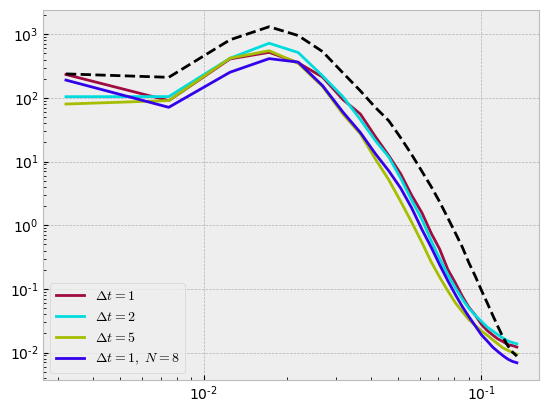

In [94]:
plt.loglog(KE_spec_1.freq_r,KE_spec_1,c=clist[0],label = r"$\Delta t = 1$")
plt.loglog(KE_spec_2.freq_r,KE_spec_2,c=clist[1],label = r"$\Delta t = 2$")
plt.loglog(KE_spec_5.freq_r,KE_spec_5,c=clist[2],label = r"$\Delta t = 5$")
plt.loglog(KE_spec_8.freq_r,KE_spec_8,c=clist[3],label = r"$\Delta t = 1,~ N = 8$")

plt.loglog(KE_spec_true.freq_r,KE_spec_true,"--k")

plt.legend(loc= "lower left")

In [73]:
N_plot = 200

KE_1, KE_true = compute_KE(N_plot,test_data,model_pred_1_short,area,wet_bool)
KE_2, KE_true = compute_KE(int(N_plot/2),test_data,model_pred_2_short,area,wet_bool)
KE_5, KE_true = compute_KE(int(N_plot/5),test_data,model_pred_5_short,area,wet_bool)
KE_8, KE_true = compute_KE(N_plot,test_data,model_pred_8_short,area,wet_bool)



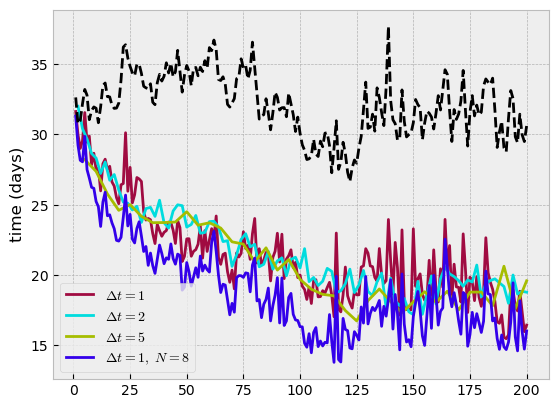

In [68]:
rho = 1020

plt.plot(np.arange(1,N_plot+1),KE_1*rho,c=clist[0],label = r"$\Delta t = 1$")
plt.plot(np.arange(2,N_plot+1,2),KE_2*rho,c=clist[1],label = r"$\Delta t = 2$")
plt.plot(np.arange(5,N_plot+1,5),KE_5*rho,c=clist[2],label = r"$\Delta t = 5$")
plt.plot(np.arange(1,N_plot+1),KE_8*rho,c=clist[3],label = r"$\Delta t = 1,~ N = 8$")

plt.plot(np.arange(1,N_plot+1),KE_true*rho,"--k")
plt.xlabel("time (days)")
plt.ylabel("Kinetic Energy")
plt.legend(loc= "lower left")

## Enstrophy
$\omega^2 = (\nabla_{h}\times \mathbf{u}_h)^2$

Enstrophy is another important physical quantity 2D, or quasi-2D turbelence and similar to energy gives a sense of spatial scales in the system. Unlike kinetic energy, which is based directly on the velocity fields, enstrophy is computed as the square of the vorticity (2D curl in this case) and give some information on how our models reproduce derivatives of the system.

In [48]:
N_plot = 200

enst_spec_1, enst_spec_true = gen_enstrophy_spectrum(N_plot,test_data,model_pred_1_short,grids,wet)
enst_spec_2, enst_spec_true = gen_enstrophy_spectrum(int(N_plot/2),test_data,model_pred_2_short,grids,wet)
enst_spec_5, enst_spec_true = gen_enstrophy_spectrum(int(N_plot/5),test_data,model_pred_5_short,grids,wet)
enst_spec_8, enst_spec_true = gen_enstrophy_spectrum(N_plot,test_data,model_pred_8_short,grids,wet)

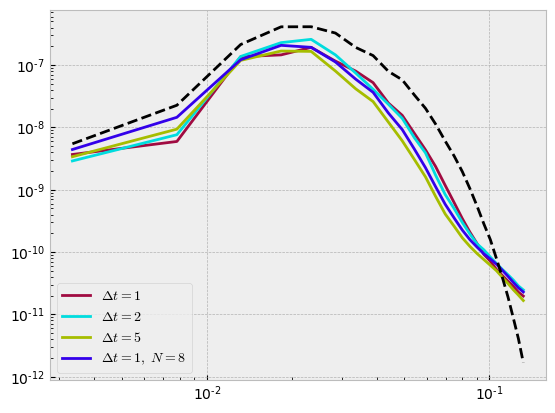

In [49]:
plt.loglog(enst_spec_1.freq_r,enst_spec_1,c=clist[0],label = r"$\Delta t = 1$")
plt.loglog(enst_spec_2.freq_r,enst_spec_2,c=clist[1],label = r"$\Delta t = 2$")
plt.loglog(enst_spec_5.freq_r,enst_spec_5,c=clist[2],label = r"$\Delta t = 5$")
plt.loglog(enst_spec_8.freq_r,enst_spec_8,c=clist[3],label = r"$\Delta t = 1,~ N = 8$")

plt.loglog(enst_spec_true.freq_r,enst_spec_true,"--k")

plt.legend(loc= "lower left")

In [80]:
N_plot = 200

enst_1, enst_true = gen_enstrophy(N_plot,test_data,model_pred_1_short,dx, dy, Nb, wet_lap)
enst_1 = enst_1.mean(axis=(1,2))
enst_2, enst_true = gen_enstrophy(int(N_plot/2),test_data,model_pred_2_short,dx, dy, Nb, wet_lap)
enst_2 = enst_2.mean(axis=(1,2))
enst_5, enst_true = gen_enstrophy(int(N_plot/5),test_data,model_pred_5_short,dx, dy, Nb, wet_lap)
enst_5 = enst_5.mean(axis=(1,2))
enst_8, enst_true = gen_enstrophy(N_plot,test_data,model_pred_8_short,dx, dy, Nb, wet_lap)
enst_8 = enst_8.mean(axis=(1,2))
enst_true = enst_true.mean(axis=(1,2))




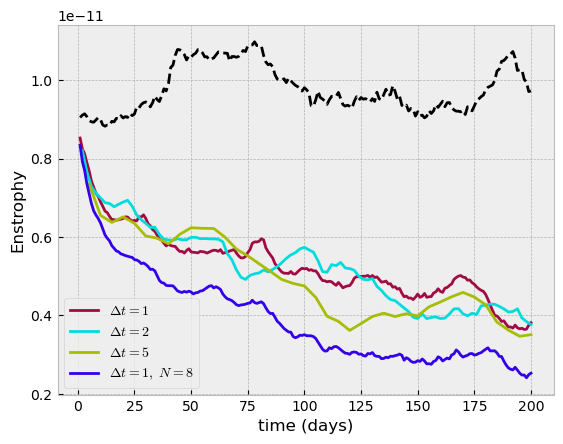

In [83]:

plt.plot(np.arange(1,N_plot+1),enst_1,c=clist[0],label = r"$\Delta t = 1$")
plt.plot(np.arange(2,N_plot+1,2),enst_2,c=clist[1],label = r"$\Delta t = 2$")
plt.plot(np.arange(5,N_plot+1,5),enst_5,c=clist[2],label = r"$\Delta t = 5$")
plt.plot(np.arange(1,N_plot+1),enst_8,c=clist[3],label = r"$\Delta t = 1,~ N = 8$")

plt.plot(np.arange(1,N_plot+1),enst_true,"--k")
plt.xlabel("time (days)")
plt.ylabel("Enstrophy")
plt.legend(loc= "lower left")

## Spatial Matching Statistics 


In [112]:
u_test = np.array(test_data[:][1][:,0]*std_out[0] +mean_out[0])
v_test = np.array(test_data[:][1][:,1]*std_out[1] +mean_out[1])
T_test = np.array(test_data[:][1][:,2]*std_out[2] +mean_out[2])

### Correlation Coefficient

The general correlation coefficient gives how well the predicted spatial field correlated with the ground truth. In slowly evolving fields such as temperature, this is dominated by seasonal changes and so this metric can remain high, even if the model is failing to capture faster, but smaller scale dynamics. 

$CC(u,\tilde{u}) = \frac{\sum_{i,j}^{N_x,N_y}A_{i,j}W_{i,j}u_{i,j}\tilde{u}_{i,j}}{\sqrt{\sum_{i,j}^{N_x,N_y}\left( A_{i,j}W_{i,j}u_{i,j} \right)^2\sum_{i,j}^{N_x,N_y}\left( A_{i,j}W_{i,j}\tilde{u}_{i,j} \right)^2}}$

In [147]:
N_eval = 200
corr_T_1, corr_T_true = compute_corrs_single(N_eval, T_test, model_pred_1_short[:,:,:,2],area, wet_bool,std_out[2],mean_out[2])
corr_T_2, corr_T_true = compute_corrs_single(int(N_eval/2), T_test, model_pred_2_short[:,:,:,2],area, wet_bool,std_out[2],mean_out[2])
corr_T_5, corr_T_true = compute_corrs_single(int(N_eval/5), T_test, model_pred_5_short[:,:,:,2],area, wet_bool,std_out[2],mean_out[2])
corr_T_8, corr_T_true = compute_corrs_single(N_eval, T_test, model_pred_8_short[:,:,:,2],area, wet_bool,std_out[2],mean_out[2])

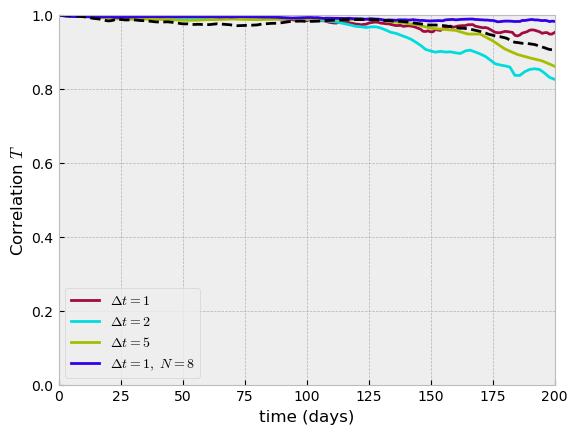

In [148]:

plt.plot(np.arange(1,N_eval+1),corr_T_1,c=clist[0],label = r"$\Delta t = 1$")
plt.plot(np.arange(2,N_eval+1,2),corr_T_2,c=clist[1],label = r"$\Delta t = 2$")
plt.plot(np.arange(5,N_eval+1,5),corr_T_5,c=clist[2],label = r"$\Delta t = 5$")
plt.plot(np.arange(1,N_eval+1),corr_T_8,c=clist[3],label = r"$\Delta t = 1,~ N = 8$")

plt.plot(np.arange(1,N_eval+1),corr_T_true,"--k")
plt.xlabel("time (days)")
plt.ylabel(r"Correlation $T$")
plt.ylim([0,1])
plt.xlim([0,N_eval])

plt.legend(loc= "lower left")

### Anomaly Correlation Coefficient

The anomaly correlation coefficient gives how well the predicted spatial field correlated with the anomalies outside of seasonality. To compute this we remove the sesonal pointwise mean from the ground truth and the prediction and then compute the correlation as is standard. For example, if we compute this for a January 30th, we average over all January 30ths and remove that from both the truth and prediction before computing the CC.

$ACC(u,\tilde{u}) = \frac{\sum_{i,j}^{N_x,N_y}A_{i,j}W_{i,j}(u_{i,j}-C_{i,j})(\tilde{u}_{i,j}-C_{i,j})}{\sqrt{\sum_{i,j}^{N_x,N_y}A_{i,j}W_{i,j}\left( u_{i,j}-C_{i,j} \right)^2\sum_{i,j}^{N_x,N_y}A_{i,j}W_{i,j}\left( \tilde{u}_{i,j}-C_{i,j} \right)^2}}$

In [145]:
N_eval = 100
ACC_T_1, ACC_T_true = compute_ACC_single(N_eval, T_test, model_pred_1_short[:,:,:,2],
                                         clim[:,:,:,2],time_test,area, wet_bool)
ACC_T_2, ACC_T_true = compute_ACC_single(int(N_eval/2), T_test, model_pred_2_short[:,:,:,2],
                                         clim[:,:,:,2],time_test,area, wet_bool)
ACC_T_5, ACC_T_true = compute_ACC_single(int(N_eval/5), T_test, model_pred_5_short[:,:,:,2],
                                         clim[:,:,:,2],time_test,area, wet_bool)
ACC_T_8, ACC_T_true = compute_ACC_single(N_eval, T_test, model_pred_8_short[:,:,:,2],
                                         clim[:,:,:,2],time_test,area, wet_bool)

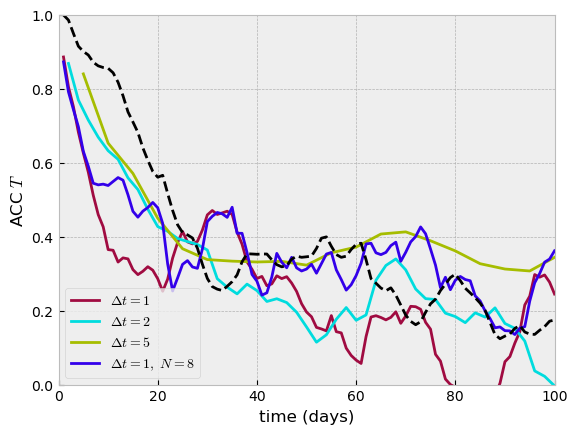

In [146]:

plt.plot(np.arange(1,N_eval+1),ACC_T_1,c=clist[0],label = r"$\Delta t = 1$")
plt.plot(np.arange(2,N_eval+1,2),ACC_T_2,c=clist[1],label = r"$\Delta t = 2$")
plt.plot(np.arange(5,N_eval+1,5),ACC_T_5,c=clist[2],label = r"$\Delta t = 5$")
plt.plot(np.arange(1,N_eval+1),ACC_T_8,c=clist[3],label = r"$\Delta t = 1,~ N = 8$")

plt.plot(np.arange(1,N_eval+1),ACC_T_true,"--k")
plt.xlabel("time (days)")
plt.ylabel(r"ACC $T$")
plt.ylim([0,1])
plt.xlim([0,N_eval])

plt.legend(loc= "lower left")

### Root Mean Squared Errror

RMSE gives a sense of how far away the prediction is from the ground truth. This distance is irrespective of the similarity in spatial patterns and would grow if two correlated fields are off by a scalar value.

$RMSE(u,\tilde{u}) = \sqrt{\frac{\sum_{i,j}^{N_x,N_y}A_{i,j}W_{i,j}(u_{i,j}-\tilde{u}_{i,j})^2}{\sum_{i,j}^{N_x,N_y}A_{i,j}W_{i,j}}}$

In [149]:
N_eval = 100
RMSE_T_1, RMSE_T_true = compute_RMSE_single(N_eval, T_test, model_pred_1_short[:,:,:,2],
                                         area, wet_bool)
RMSE_T_2, RMSE_T_true = compute_RMSE_single(int(N_eval/2), T_test, model_pred_2_short[:,:,:,2],
                                         area, wet_bool)
RMSE_T_5, RMSE_T_true = compute_RMSE_single(int(N_eval/5), T_test, model_pred_5_short[:,:,:,2],
                                         area, wet_bool)
RMSE_T_8, RMSE_T_true = compute_RMSE_single(N_eval, T_test, model_pred_8_short[:,:,:,2],
                                         area, wet_bool)

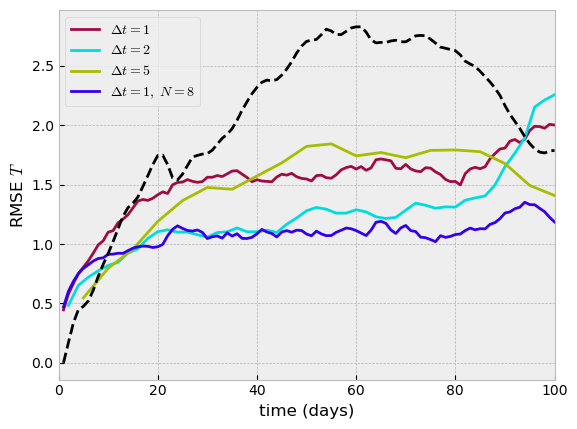

In [152]:

plt.plot(np.arange(1,N_eval+1),RMSE_T_1,c=clist[0],label = r"$\Delta t = 1$")
plt.plot(np.arange(2,N_eval+1,2),RMSE_T_2,c=clist[1],label = r"$\Delta t = 2$")
plt.plot(np.arange(5,N_eval+1,5),RMSE_T_5,c=clist[2],label = r"$\Delta t = 5$")
plt.plot(np.arange(1,N_eval+1),RMSE_T_8,c=clist[3],label = r"$\Delta t = 1,~ N = 8$")

plt.plot(np.arange(1,N_eval+1),RMSE_T_true,"--k")
plt.xlabel("time (days)")
plt.ylabel(r"RMSE $T$")
plt.xlim([0,N_eval])

plt.legend()